## Group: Stanley


### Authors:
- Ana Alum Urbina 100475297 
- Alejo González García 100454351
- Alonso Madroñal de Mesa 100454449
- Andrés Navarro Pedregal 100451730
- Irina Vela Gómez 100454302

In [49]:
from IPython.display import Image, display

In [50]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import random

## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2023

&nbsp;
&nbsp;
&nbsp;
# Lab 3. Unsupervised Learning with Kernel Methods

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Optical recognition of handwritten digits dataset

The [optical recognition of handwritten digits dataset](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) is another classic benchmark from the UCI repository. The dataset contains $8\times 8$ matrices obtained processing bitmaps of handwritten digits from preprinted forms. 

The original bitmaps are $32\times 32$ pixels. The observations are the result of divinding these bitmaps into nonoverlapping $4\times 4$ and counting the number of black pixels in each block. Therefore observations are rows of integers that take values between 0 and 16. A value of $0$ means the block $4\times 4$ block in that position was a blank block while a value of 16 indicates all the pixels of that block were inked. 

There are 10 classes, with class names 0 to 9, each class name refers to the corresponding digit.

Each observation can be regarded as a low resolution image of each original handwritten digit. 

In [52]:
from sklearn.datasets import load_digits

data = load_digits()
X = data['data']
Y = data['target']
print("{0:d} observations with {1:d} columns".format(X.shape[0], X.shape[1]))
print("{0:d} targets".format(len(Y)))
print("Values of the targets:")
print(np.unique(Y))

1797 observations with 64 columns
1797 targets
Values of the targets:
[0 1 2 3 4 5 6 7 8 9]


## Plot some examples

The function `plot_ten_examples` receives ten rows with observations in argument `X` and their corresponding targets in argument `y` and plots the digits.


In [53]:
def plot_ten_examples(X,y, score=None):
  nrows = 2
  ncols = 5
  ff,aa = plt.subplots(nrows, ncols,figsize=(12,2))
  ii = 0
  for rr in range(nrows):
    for cc in range(ncols):
      aa[rr][cc].set_axis_off()
      aa[rr][cc].imshow(X[ii].reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
      if score is None:
        aa[rr][cc].set_title('Target: {0:d}'.format(y[ii]))
      else:
        aa[rr][cc].set_title('Target: {0:d}, score:{1:.3f}'.format(y[ii], score[ii]))
      ii += 1
  ff.tight_layout()    

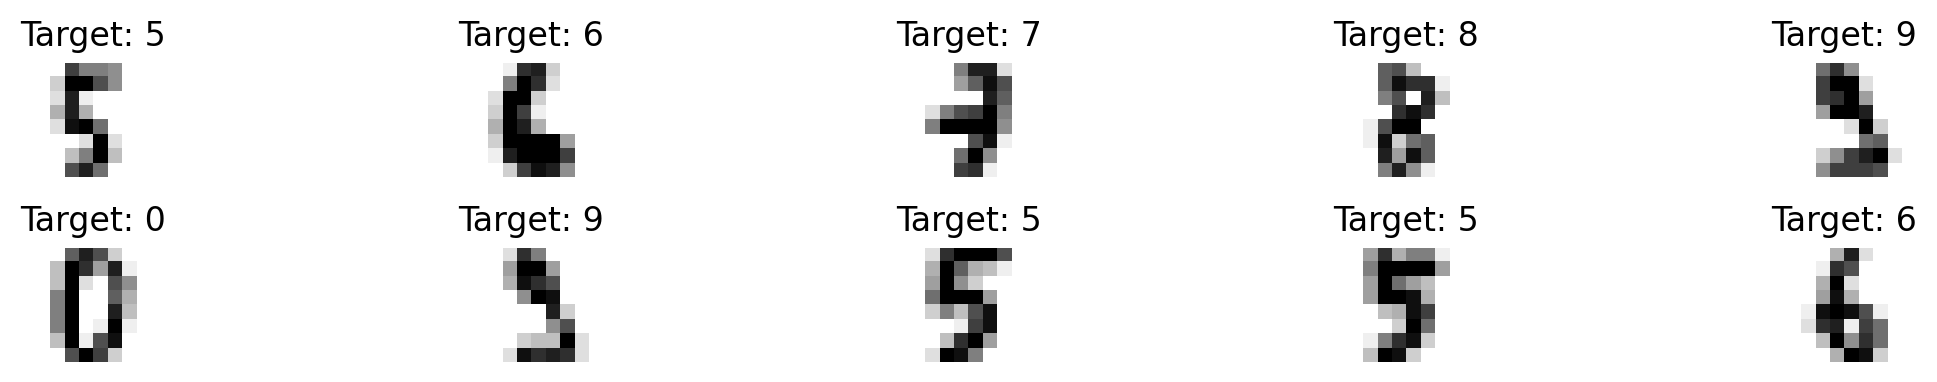

In [54]:
# plot digits in rows 25 to 34 in X
plot_ten_examples(X[25:35,:],Y[25:35])

## Separation in training and test set

First partition the dataset moving a 50% of the observations to the training set and  and the remaining 50% to the test set. 

For simplicity, use the names `X_train, X_test, y_train, y_test` for the corresponding numpy arrays.


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.5,random_state=42)

# 1. Definition of the novelty detection tasks

In this assignment you are going to work with different degrees of supervision in three novelty detection tasks. These novelty detection tasks will be simulated using classification tasks in which we will alter the training set by removing partially or totally the instances of some digits. The test set will be always the same, therefore the novelty stands in the fact that in the test set there will be members of digits that were not present (or very poorly represented) in the training set. 


The novelty detections tasks are the following:

1. The training set is formed exclusively by instances of 5. As the test set has instances of all digits, the novelty is the presence of instances of digits different from 5.
2. The training set has no instances of digits 5,6,7,8 and 9. The novelty is the presence of examples of digits 5,6,7,8 and 9 in the test set.

We have prepared two python functions that receive generic training and test set (observations are images of all the digits and targets are integers between 0 and 9) and output the training set observations and labels and the test set labels. Notice the test set observations are always the same.

The functions are `just_fives` and `zero_four`. For example, for the first novelty detection task, where the training set only has instances of digit 5, one should create the corresponing sets using:

`x_train_5, y_train_5, y_test_5, = just_fives(X_train, y_train, y_test, number_novel_instances=0)`

- `x_train_5`: rows of `X_train` that correspond with instances of digit 5. If `number_novel_instances`> 0, there will be some rows in `x_train_5` with instances of other digits.

- `y_train_5`: true binary labels of the rows of `x_train_5` for computing classification scores. If row $i$ of `x_train_5` is an instance of digit 5, then `y_train_5[i]` is 1. Otherwise `y_train_5[i]` is -1.

- `y_test_5`: true binary labels of the rows of `X_test` for computing classification scores. If row $i$ of `X_test` is an instance of digit 5, then `y_test_5[i]` is 1. Otherwise `y_test_5[i]` is -1.

- `number_novel_instances`: number of instances of other digits than 5 in `x_train_5` and `y_train_5`. A value of `number_novel_instances` = $k$ means that the last $k$ rows of `x_train_5` will contain instances of digits different from 5, and therefore the last $k$ elements of `y_train_5` will be -1. Notice $k$ must be smaller than the number of non-five digits in `X_train`.






In [56]:
def just_fives(x_train, y_train, y_test, number_novel_instances=0):
  
  is_5 = np.where(y_train==5)[0]
  n5 = len(is_5)
  xr = x_train[is_5,:].copy()
  yr = np.ones(n5, dtype='int')
  yt = -np.ones(len(y_test), dtype='int')
  yt[y_test==5] = 1
  
  
  if number_novel_instances > 0:
    n_not_5 = len(y_train) - n5
    if number_novel_instances < n_not_5:
      my_idx_negs = random.sample(range(n_not_5), k=number_novel_instances)
    else:
      my_idx_negs = range(n_not_5)
    is_not_5 = np.where(y_train != 5)[0][my_idx_negs]
    
    xr = np.vstack((xr, x_train[is_not_5,:].copy()))
    yr = np.hstack((yr, -np.ones(len(is_not_5), dtype='int')))
  
    
  return xr, yr, yt


def zero_four(x_train, y_train, y_test, number_novel_instances=0):
  is_5 = np.where(y_train < 5)[0]
  n5 = len(is_5)
  xr = x_train[is_5,:].copy()
  yr = np.ones(n5, dtype='int')
  yt = np.ones(len(y_test), dtype='int')
  yt[y_test>=5] = -1
  
  
  if number_novel_instances > 0:
    n_not_5 = len(y_train) - n5
    if number_novel_instances < n_not_5:
      my_idx_negs = random.sample(range(n_not_5), k=number_novel_instances)
    else:
      my_idx_negs = range(n_not_5)
    
    is_not_5 = np.where(y_train >= 5)[0][my_idx_negs]
    xr = np.vstack((xr, x_train[is_not_5,:].copy()))
    yr = np.hstack((yr, -np.ones(len(is_not_5), dtype='int')))

  return xr, yr, yt

## 1.1 Evaluation of the performance

In this assignment you will use the **confusion matrix** to evaluate the performance of the methods. The confusion matrix captures all the possible outcomes of a classifier. In a multiclass classification problem with $M$ classes, the confusion matrix is a $M\times M$ matrix $C$ where position $M_{ij}$ counts the number of instances of class $i$ in the test set that were predicted as instances of class $j$ by the classifier. Therefore large numbers in main diagonal of $C$ indicate a successful performance while the elements in off-diagonal positions account for errors.

In a binary classification problem (and the novel detection can be cast as a binary classification setting where the positive class is formed by normal observations and the negative class is formed by the novel observations) each output of the classifier can be categorized in one of these groups:
- True positive (TP): test observations whose true class is the positive one and the classifier correctly classifies

- False negative (FN): test observations whose true class is the positive one but the classifier classifies as negative

- True negative (TN): test observations whose true class is the negative one and the classifier correctly classifies

- False positive (FP): test observations whose true class is the negative one but the classifier classifies as positive. 

With this notation the confusion matrix in a binary case is
$$
C = \left [ \begin{array}{cc} TN & FP \\ FN & TP \end{array}\right ]
$$
For normalization purposes, the rows of $C$ add up to the number of test observations in each true class while the columns of $C$ add up to the number of test observations classified to each class.

The confusion matrix is implemented in sklearn in function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

# 2. One-Class SVM for novelty detection.
The first exercise of the assignment consists in to evaluate the capabilities of the sklearn implementation of One-class SVM [One-class SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) as novelty detector.

You are using RBF kernels and to avoid tunig the value of $\gamma$ use a value `gamma= "scale"`.

There is a key parameter in the implementation of OneClassSVM called `nu`. This parameter controls the regularization (similar role to $C$) in the sense that `nu` is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. Should be in the interval $(0, 1]$. For instance `nu=0.3` means that at least 30% of the training data will become support vectors, that is, they will en up either on the margin (being inliers) or on the wrong side of the margin. Some of the support vectors on the wrong side of the margin will eventually become outliers as they will be also on the wrong side of the classification boundary (in this case the classification boudnary separates inliers from outliers). This is why `nu` can be considered an upper bound for the number of errors.

## 2.1. Training set with only fives case.

First use function `just_fives` to obtain the data corresponding to the task in which there are only instances of 5 in the training set.


In [57]:
X_train_5, y_train_5, y_test_5 = just_fives(X_train, y_train, y_test,0.)

### 2.1.1 Dependence with `nu`

Complete the code of the following function that will help you study the performance of OneClassSVM in this novelty detection task. 

Consider the following range of variation of `nu`:
$$
nu \in \{ 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2\}
$$

In [58]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
def simulate_oneclasssvm_nu(x_train, x_test, y_train, y_test, range_nu):
  tn = np.empty(len(range_nu)) # true negatives for every value of nu
  fp = np.empty(len(range_nu)) # false positives for every value of nu
  fn = np.empty(len(range_nu)) # false negatives for every value of nu
  tp = np.empty(len(range_nu)) # true positives for every value of nu

    
  for i, n in enumerate(range_nu):
    model =  OneClassSVM(gamma = 'scale', nu = n)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    cm = confusion_matrix(y_test, y_pred)
    tn[i] = cm[0, 0]
    fp[i] = cm[0, 1]
    fn[i] = cm[1, 0]
    tp[i] = cm[1, 1]
    
  """
  YOUR CODE

  Implement a loop that iterates over the values of range_nu. For each iteration
  1. instantiate a OneClassSVM with the value of nu fixed to one that corresponds 
    to the current iteration
  2. train the OneClassSVM with x_train and y_train
  3. predict the outlier or inlier condition for the rows of x_test
  4. call confusion_matrix to obtain TN, FP, FN, TP and fill the corresponding
     position of arrays tn, fp, fn and tp
  """
  return tn, fp, fn, tp

#### Plot the dependence of the performance with nu

Call `simulate_oneclasssvm_nu` with the outcome of `just_fives` and plot the evolution of true negatives, false positives, false negatives and true positives in the novelty detection as `nu` varies. 

Discuss:
- What is the method better at? 
  - detecting 5s in the test set
  - detecting novelties in the test set 

- How is the variation of the performance with `nu`? Any explanation?

Hint: use logarithmic scale in the x-axis, to better accommodate the selected range for `nu` 

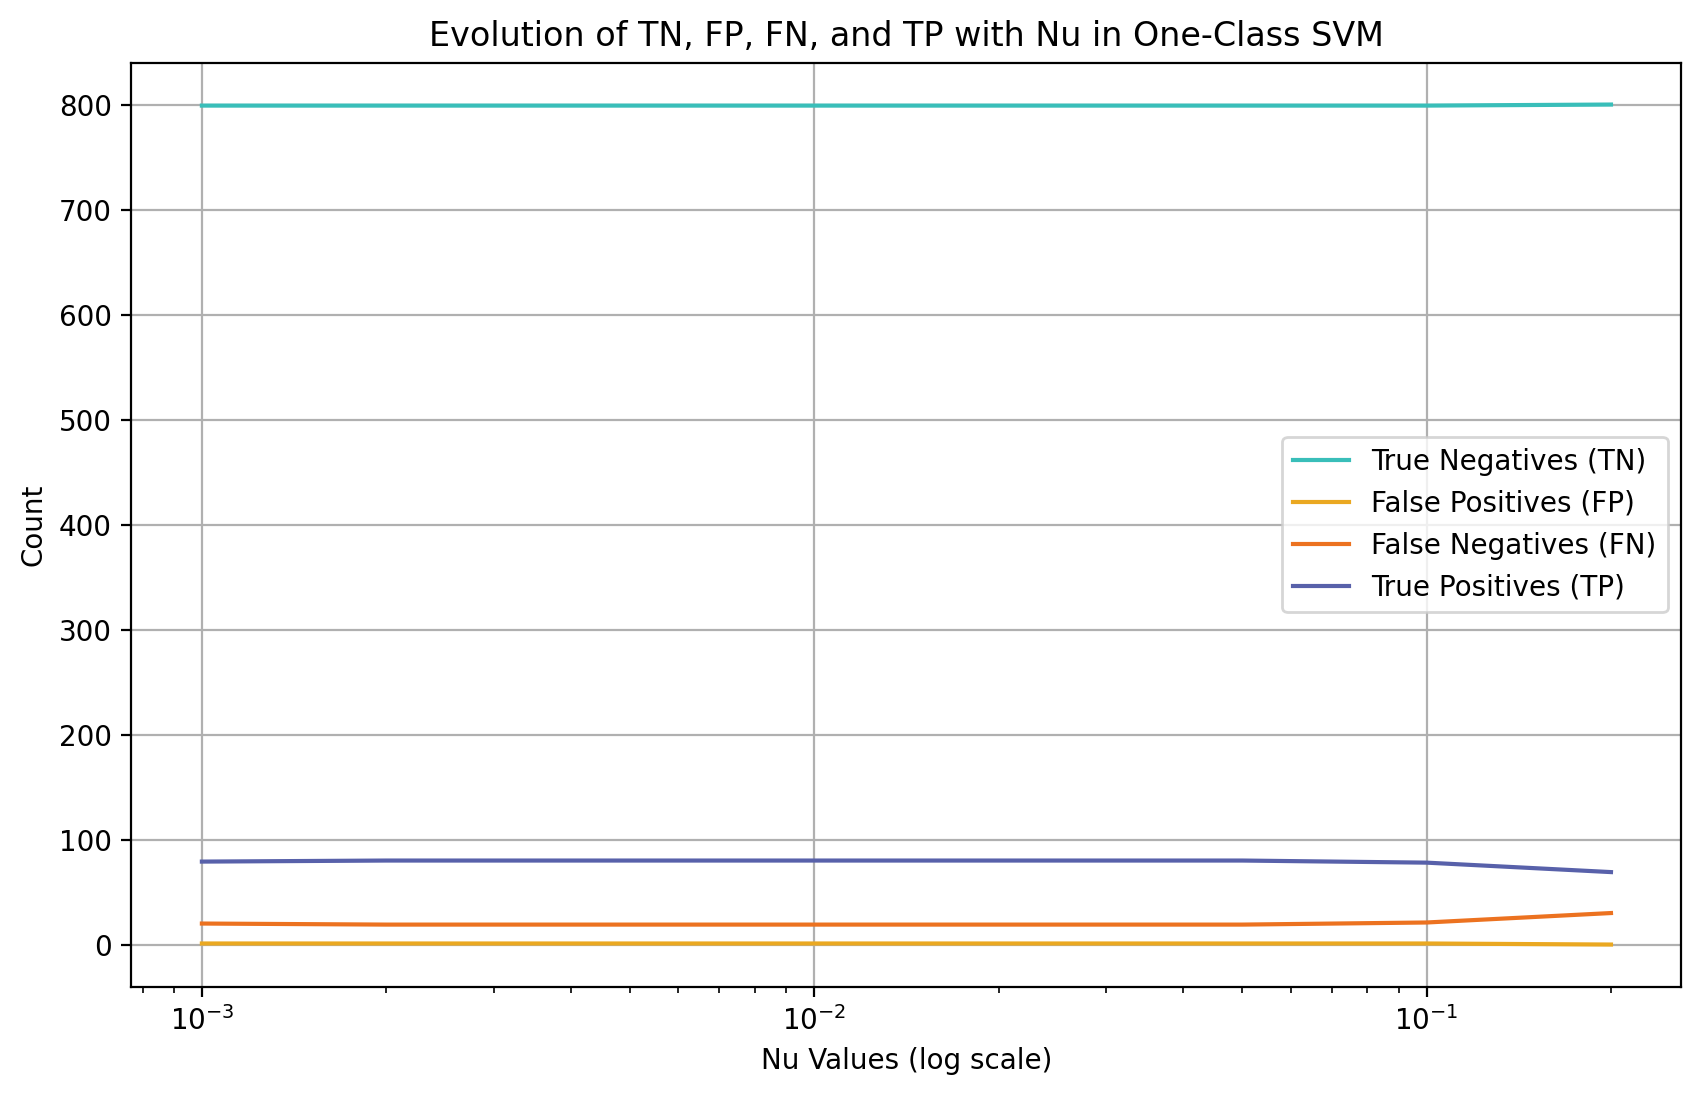

In [59]:
range_nu = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2]
tn, fp, fn, tp = simulate_oneclasssvm_nu(X_train_5, X_test, y_train_5, y_test_5, range_nu)
plt.figure(figsize=(10, 6))
plt.plot(np.array(range_nu), tn, label='True Negatives (TN)', color = '#39beb9' )
plt.plot(range_nu, fp, label='False Positives (FP)', color = '#eaa821')
plt.plot(range_nu, fn, label='False Negatives (FN)', color = '#ec7220')
plt.plot(range_nu, tp, label='True Positives (TP)', color = '#5861aa')
plt.xlabel('Nu Values (log scale)')
plt.ylabel('Count')
plt.title('Evolution of TN, FP, FN, and TP with Nu in One-Class SVM')
plt.legend()
plt.xscale("log")
plt.grid(True)
plt.show()


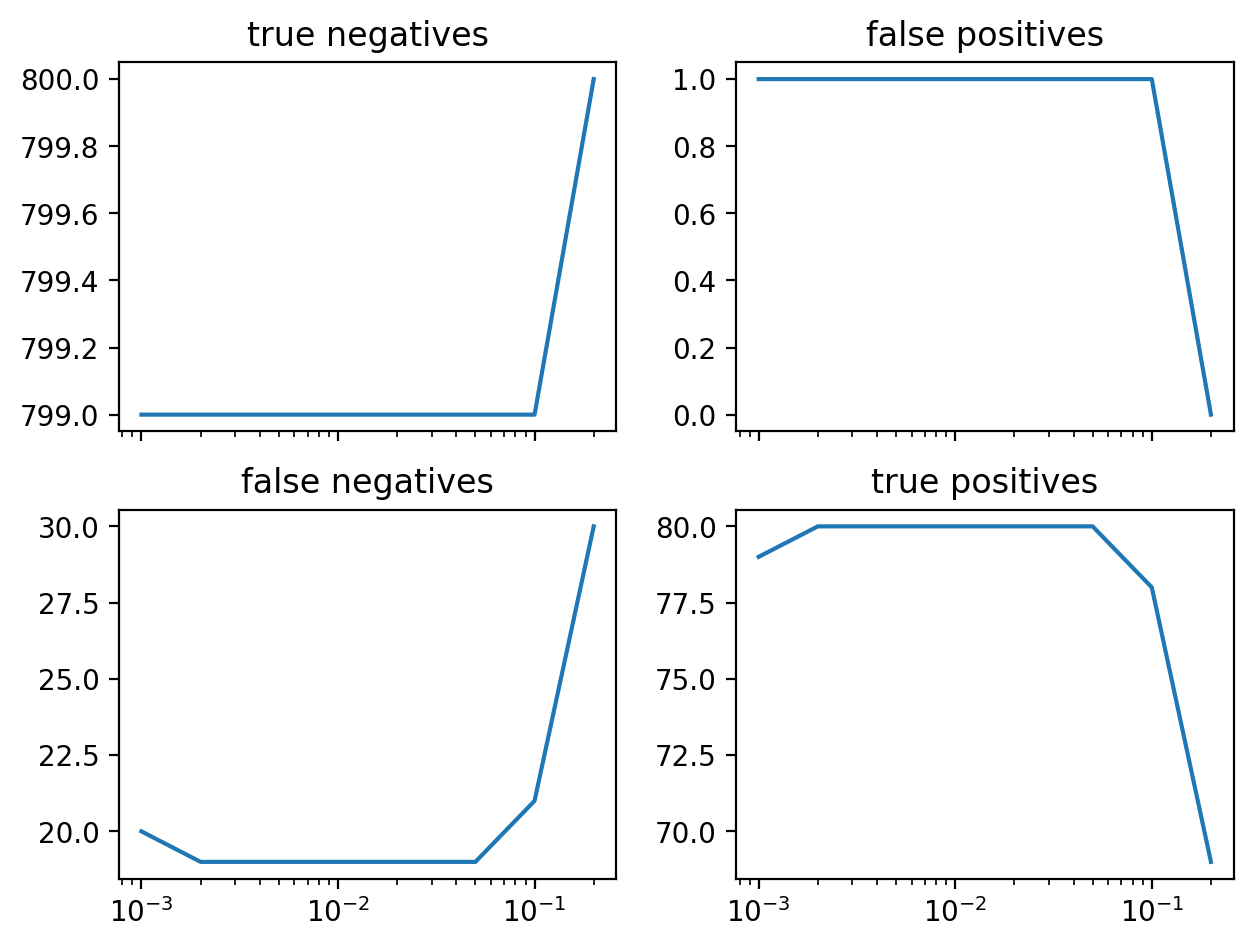

In [60]:

from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, sharex=True)

axs[0][0].plot(range_nu, tn)
axs[0][0].set_title("true negatives")
axs[0][1].plot(range_nu, fp)
axs[0][1].set_title("false positives")
axs[1][0].plot(range_nu, fn)
axs[1][0].set_title("false negatives")
axs[1][1].plot(range_nu, tp)
axs[1][1].set_title("true positives")
fig.tight_layout(pad=1.0)
plt.xscale("log")
plt.show()

**Your discussion**

This method is better finding 5's in the test set rather than detecting novelties. This is because the true negatives and true positives are always high and more or less remain constant. Therefore it is good at finding novelties as the false negatives are relatively low, this is when it finds something that is a five but it is classified as non-five.

The performance does not seem to be much affected from the variation of nu. nu = 10^-2 seems to be a good choice, however, other values from 10^-3 to 10^-1, give the same confusion matrix. Bit if nu is too large, then it just focuses on predicting novelties even if they are wrong.

### 2.1.2 Qualitative analysis

Select a value of `nu` with good performance, train a OneClassSVM with the outcome of `just_fives` and obtain the score (real valued ouput, not label) for the test set observations.

Use the function `plot_ten_examples` to plot the 5 observations with the highest score and the 5 observations with the lowest score within the test observations whose true class is 5.

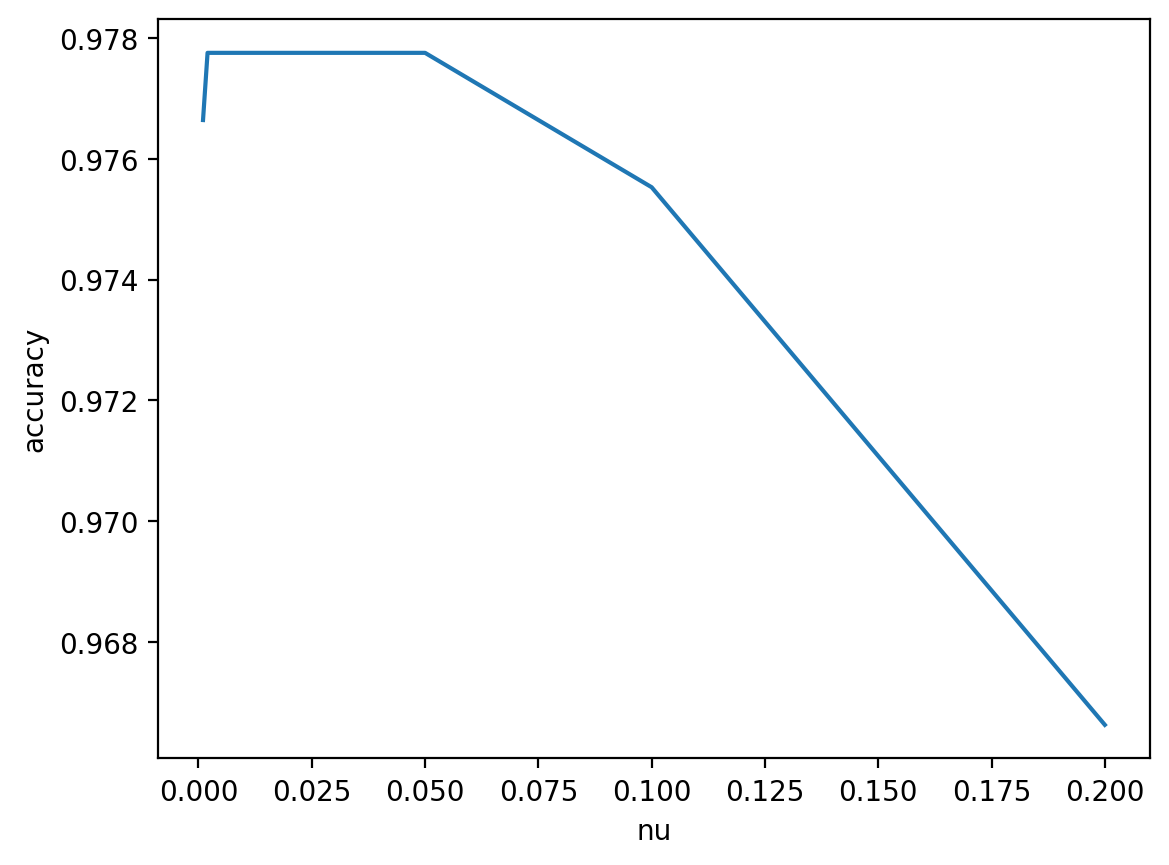

In [61]:
plt.plot(range_nu, ((tn+tp) / (tn+tp+fp+fn)))
plt.ylabel("accuracy")
plt.xlabel("nu")
plt.show()

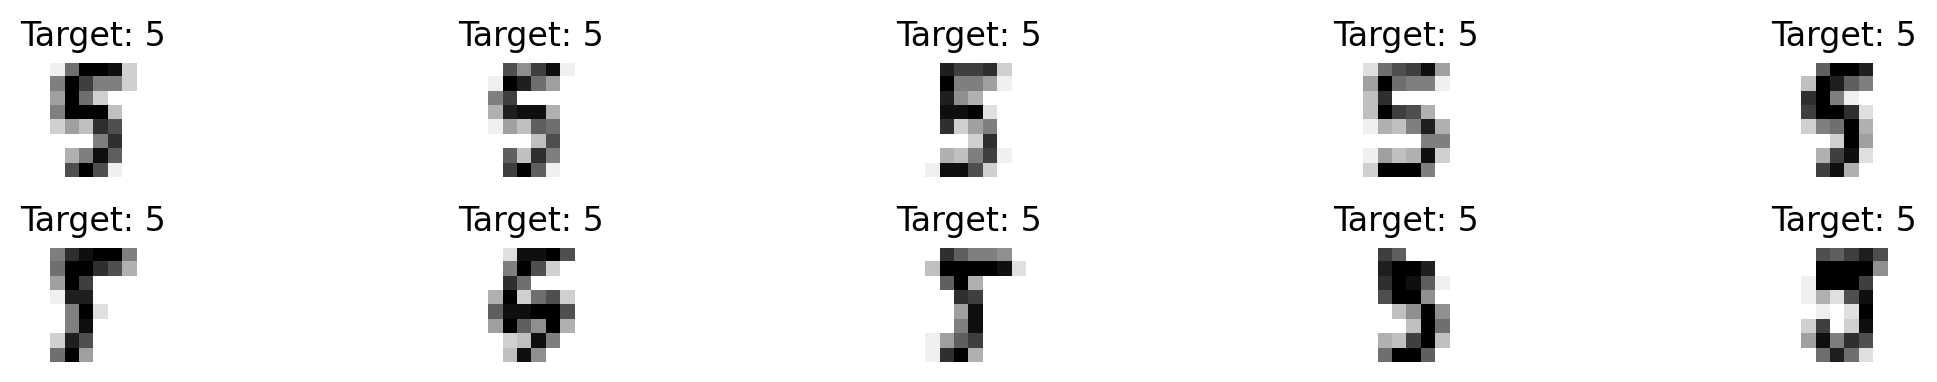

In [62]:
nu_1 = 0.001 

# Model training 
one_svm_rbf = OneClassSVM(kernel="rbf", gamma="scale",nu = nu_1)
one_svm_rbf.fit(X_train_5, y_train_5)
score1 = one_svm_rbf.score_samples(X_test); #print(score1)

# Get the score and the index of the elements which y=1. 
scores_5 = []
index_5 = []
for i in range(len(y_test_5)):
    if y_test_5[i] == 1:
        index_5.append(i)
        scores_5.append(round(score1[i],4))
# This 2 lists store the index and the scores of the elements of X_test that have y=1 (true binary levels)
# Now we are going to get the 5 best and worst scores, and we are going to store the index, so that we can
# retrieve X_test[10_scores]. 

# Combine the two lists using zip, and sort by the score in descending order
sorted_data = sorted(zip(index_5, scores_5), key=lambda x: x[1], reverse=True)

# Get the top and low 5 elements
top_N = low_N = 5
top_elements = sorted_data[:top_N]
low_elements = sorted_data[-low_N:]

# Extract the values corresponding to the top scores
top_X_test_values = [scores_5 for x, scores_5 in top_elements]
low_X_test_values = [scores_5 for x, scores_5 in low_elements]

# Now store the 10 arrays in a list called values. 
values = []
y_1 = []
for i in top_elements:
    values.append(X_test[i[0]])
    y_1.append(y_test[i[0]])

for i in low_elements:
    values.append(X_test[i[0]])
    y_1.append(y_test[i[0]])


# Plot the 10 examples: 
plot_ten_examples(values,y_1)

In [63]:
print(top_X_test_values)
print(low_X_test_values)

[0.0429, 0.0428, 0.0417, 0.0411, 0.0411]
[0.0325, 0.0311, 0.0302, 0.0292, 0.0261]


Do the same plot with the observations in the test set whose true class is not 5

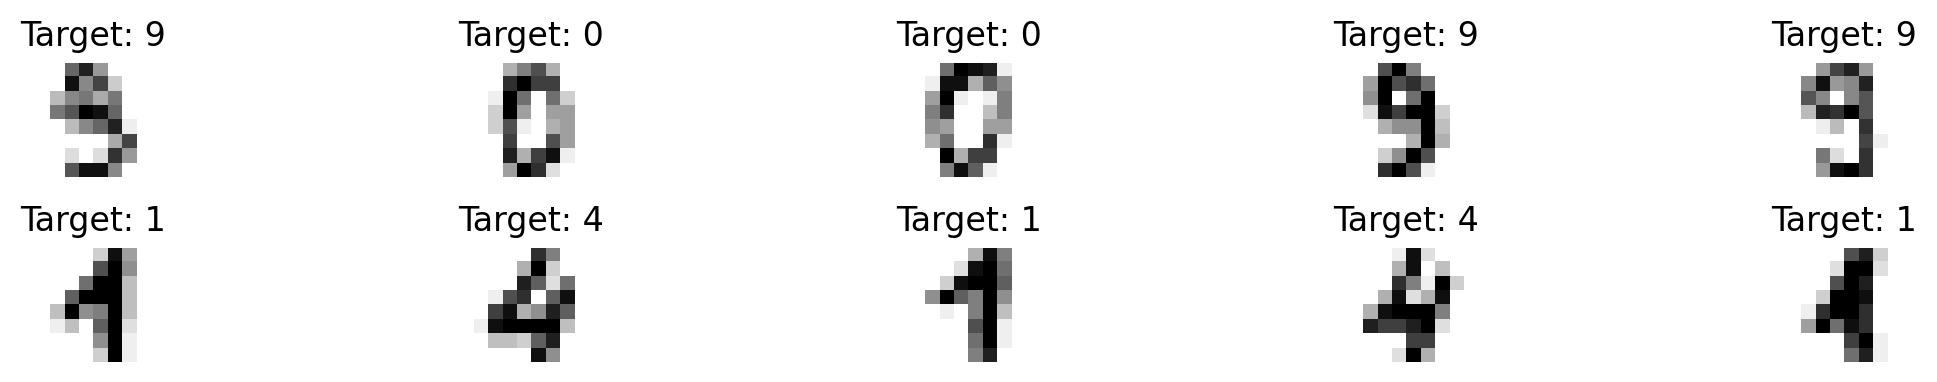

In [64]:
scores_5_2 = []
index_5_2 = []
for i in range(len(y_test_5)):
    if y_test_5[i] != 1:
        index_5_2.append(i)
        scores_5_2.append(round(score1[i],4))



sorted_data_2 = sorted(zip(index_5_2, scores_5_2), key=lambda x: x[1], reverse=True)


top_N = low_N = 5
top_elements_2 = sorted_data_2[:top_N]
low_elements_2 = sorted_data_2[-low_N:]

top_X_test_values_2 = [scores_5 for x, scores_5 in top_elements_2]
low_X_test_values_2 = [scores_5 for x, scores_5 in low_elements_2]

values = []
y_1 = []
for i in top_elements_2:
    values.append(X_test[i[0]])
    y_1.append(y_test[i[0]])

for i in low_elements_2:
    values.append(X_test[i[0]])
    y_1.append(y_test[i[0]])



# Plot the 10 examples: 
plot_ten_examples(values,y_1)

In [65]:
print(top_X_test_values_2)
print(low_X_test_values_2)

[0.0368, 0.0352, 0.0344, 0.0342, 0.034]
[0.0158, 0.0157, 0.0157, 0.0153, 0.0149]


**Comment on the aspect of these examples. Do the negative examples with the highest score look like 5s?**

**How are the scores of the negative examples that achieved the highest scores compared with the scores of the positive examples that achieved the lowest scores?**

- For a human maybe not, as we can recognize easily the characteristic shapes. However they share specific curves with the fives and in a determinate gray scale that might be the thing that is confusing the computer. For example the first 9, it is really fuzzy and a human can also be confused, as it is really similar to a 5.

- The score of the negative examples that scored the highest are bigger than those that were 5's but with the lowest scores. This is really interesting as we see that the algorithm things that the negative examples are more 5 than the real fives. But if we take a closer look at the number, they are 9 and 0 that have a lot of common characteristics from the 5.

## 2.2. Training set without 5, 6, 7, 8, and 9.

First use function `zero_four` to obtain the data corresponding to the task in which there are no instances of 5, 6, 7, 8 and 9 in the training set.


In [66]:
X_train_04, y_train_04, y_test_04 = zero_four(X_train, y_train, y_test,0.)

### 2.2.1 Dependence with `nu`

Repeat step 2.1.1 with this novelty detection task data.


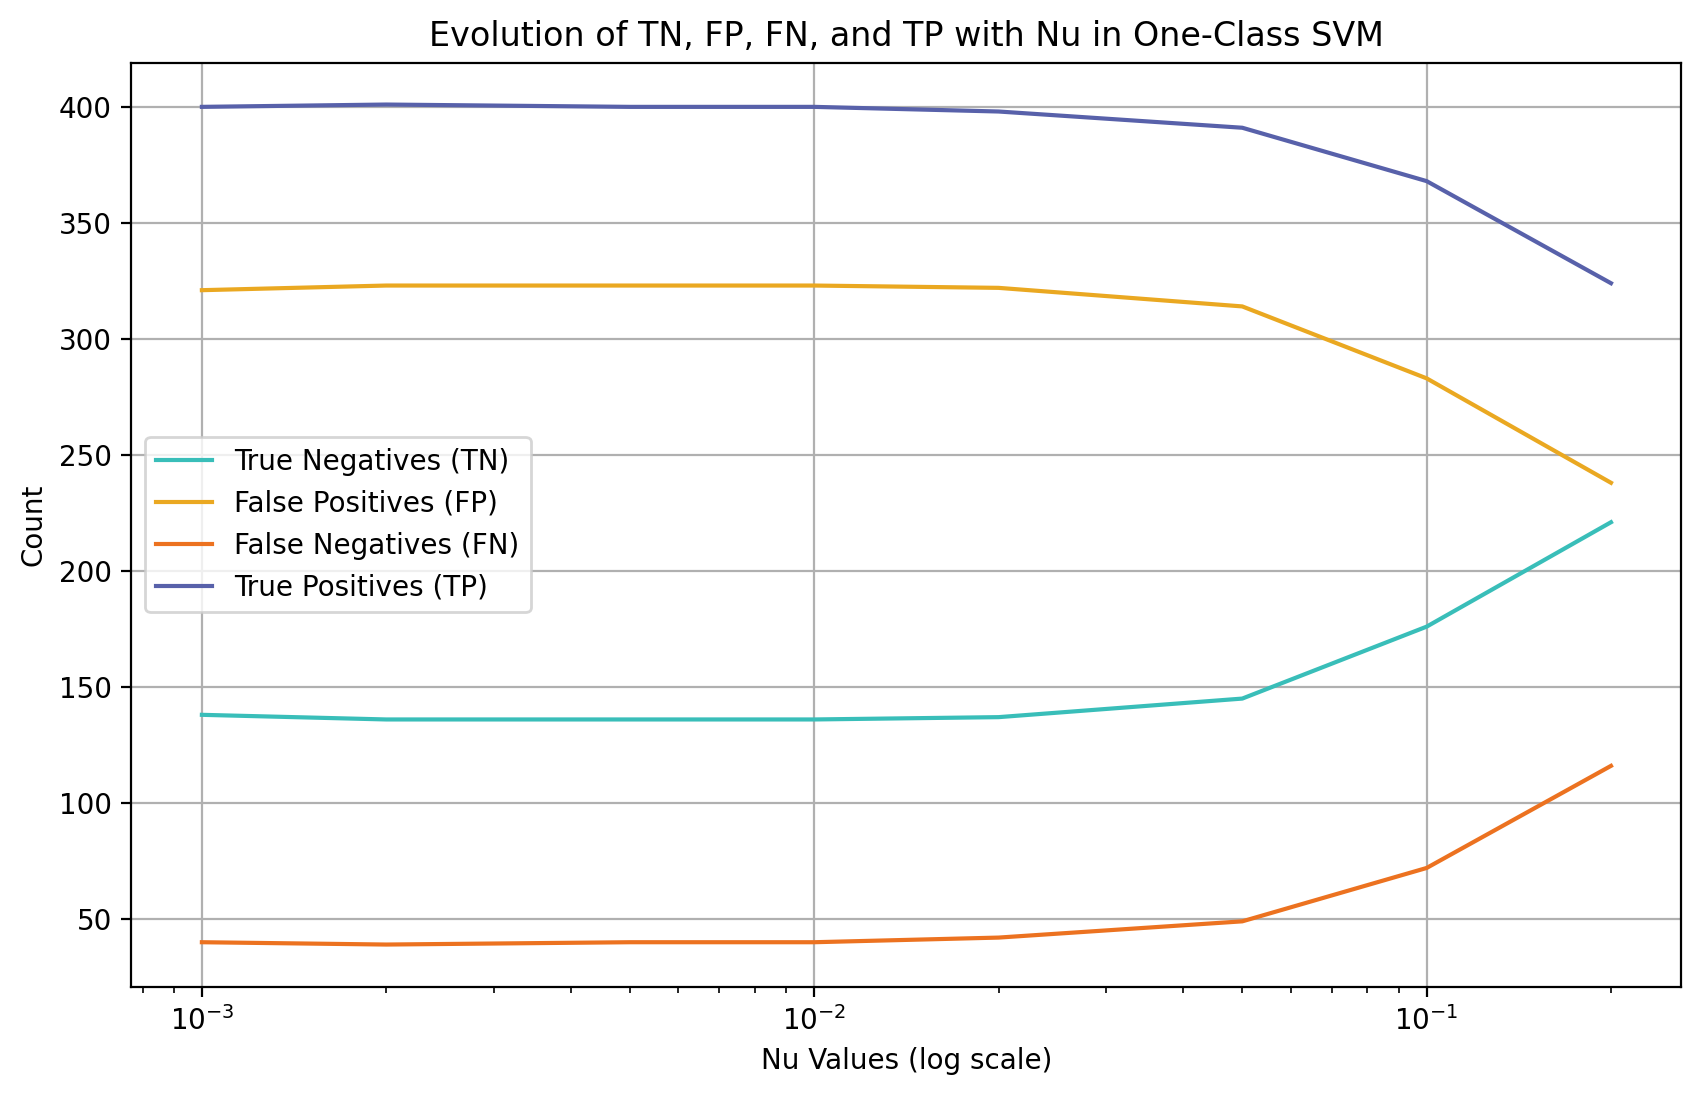

In [67]:
range_nu = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2]
tn_04, fp_04, fn_04, tp_04 = simulate_oneclasssvm_nu(X_train_04, X_test, y_train_04, y_test_04, range_nu)
plt.figure(figsize=(10, 6))
plt.plot(np.array(range_nu), tn_04, label='True Negatives (TN)', color = '#39beb9' )
plt.plot(range_nu, fp_04, label='False Positives (FP)', color = '#eaa821')
plt.plot(range_nu, fn_04, label='False Negatives (FN)', color = '#ec7220')
plt.plot(range_nu, tp_04, label='True Positives (TP)', color = '#5861aa')
plt.xlabel('Nu Values (log scale)')
plt.ylabel('Count')
plt.title('Evolution of TN, FP, FN, and TP with Nu in One-Class SVM')
plt.legend()
plt.xscale("log")
plt.grid(True)
plt.show()


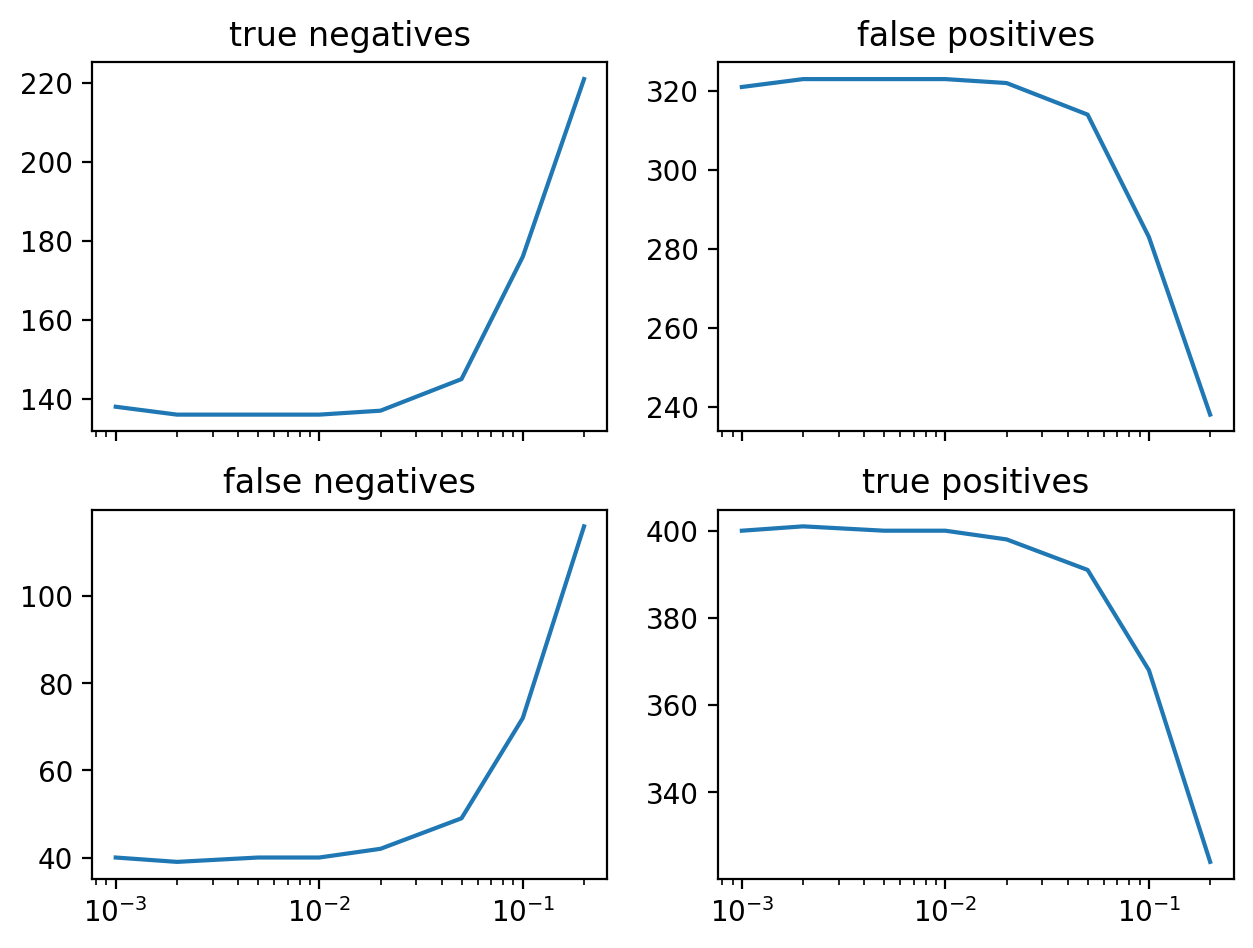

In [68]:

from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, sharex=True)

axs[0][0].plot(range_nu, tn_04)
axs[0][0].set_title("true negatives")
axs[0][1].plot(range_nu, fp_04)
axs[0][1].set_title("false positives")
axs[1][0].plot(range_nu, fn_04)
axs[1][0].set_title("false negatives")
axs[1][1].plot(range_nu, tp_04)
axs[1][1].set_title("true positives")
fig.tight_layout(pad=1.0)
plt.xscale("log")
plt.show()

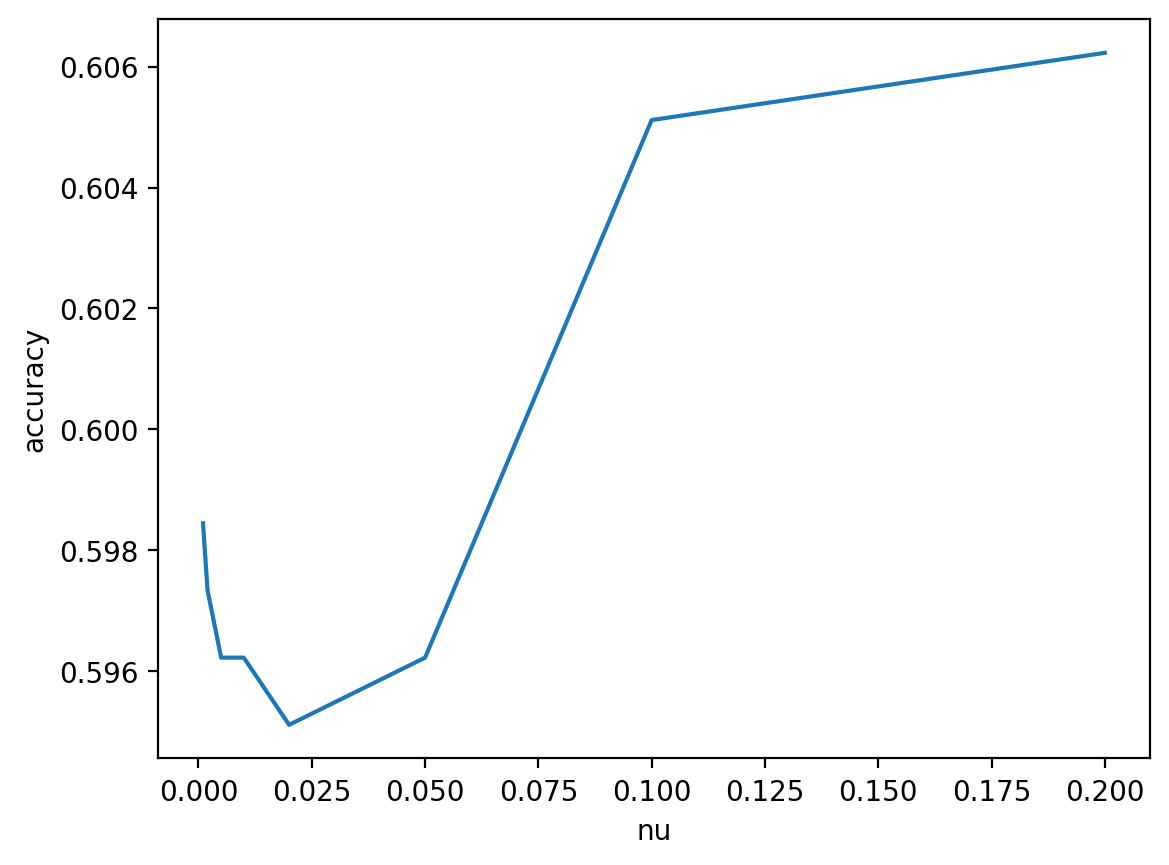

In [69]:

plt.plot(range_nu, ((tn_04+tp_04) / (tn_04+tp_04+fp_04+fn_04)))
plt.ylabel("accuracy")
plt.xlabel("nu")
plt.show()

**Discussion** Comment on the differences in performance with the other two tasks. 

This third task is closer to the task training with just 5s or to training without 5s?

In this case the performance is notably worse. This can be seen as the True Negatives are way lower and the True Positives too. This may be because in the previous case we were training it only with 5's and now we've got a lot of different examples. As we are training a model with a lot of different digits, it will have less training examples per class so it won't be able to train more in depth for each class. This is beacuse the main goal of this model is to differentiate between classes 0 to 4 from classes 5 to 9. However a `nu = 0.01` might still be the best option.

The main difference is that for low values of nu there is a high number of false positives and as we increase it, the number of false negatives increases proportionally and the FP decreases.

# 3. Introducing supervision
In this part you will explore the advantages of incorporating supervised learning in the form of a few instances of the negative class

Previously complete the code of the function `simulate_svm` that will help you with the experiments of this section. 

In [70]:
from sklearn.svm import SVC
def simulate_svm(x_train, x_test, y_train, y_test, fun, range_number_negatives):
  # fun: function that obtains the data for each novelty detection task.
  #      it can take the values no_fives, just_fives, zero_four. And yes, 
  #      in python functions can receive other functions as arguments
  # range_number_negatives: list with the number of samples in the negative 
  #                         class that you want in the training set to simulate
  #                         a novelty detection task with partial supervision

  tn = np.empty(len(range_number_negatives))
  fp = np.empty(len(range_number_negatives))
  fn = np.empty(len(range_number_negatives))
  tp = np.empty(len(range_number_negatives))
  model =  SVC(C = 1e4,kernel = 'rbf', gamma = 'scale')

  for i, value in enumerate(range_number_negatives):
        aux_x_train, aux_y_train, aux_y_test = fun(x_train, y_train, y_test,value)
        model.fit(aux_x_train, aux_y_train)
        test_accuracy = model.predict(x_test)
        cm = confusion_matrix(aux_y_test, test_accuracy)
        tn[i] = cm[0, 0]
        fp[i] = cm[0, 1]
        fn[i] = cm[1, 0]
        tp[i] = cm[1, 1]
  """
  YOUR CODE
  1. create a SVM for classification with RBF kernel, C fixed to 1e4 and a 
     value of gamma set to 'scale'
  2. Loop for all the values in range_number_negatives
     2.1 call fun to obtain the data to simulate a partially supervised novelty
         detection task with the number of observations of the negative class in
         the trainining set corresponding to this iteration of the loop
     2.2 train the SVM with the outcome of step 2.1
     2.3 get the class predictions for the test set
     2.4 call confusion_matrix with y_test and the outcome of point 2.3 and 
         fill the positions in tn, fp, fn and tp corresponding to this iteration
         of the loop  
  """
  return tn, fp, fn, tp

## 3.1 Supervision in the only 5s task

Obtain a logarithmic range for the values of the number of instances of the negative class (non 5s) in the training set. Use 10 values between 1 and the maximum value equal to the number of non 5s in the training set.

Hint: numpy logspace could serve for this purpose. And remember the elements in the range should be integers...

In [71]:
MAX_VALUE = len(y_test_5 == -1);
log_range = np.logspace(0, np.log10(MAX_VALUE), num=10, endpoint=True, base=10, dtype=int)

Call `simulate_svm` to obtain the variation of TN, FP, FN and TP as the supervision of the problem increases.

Make a plot with the evolution of these 4 performance metrics. To compare with the unsupervised part, in this plot, show with **constant** dashed lines the values for  TN, FP, FN and TP obtained by OneClassSVM with the best value of `nu`.

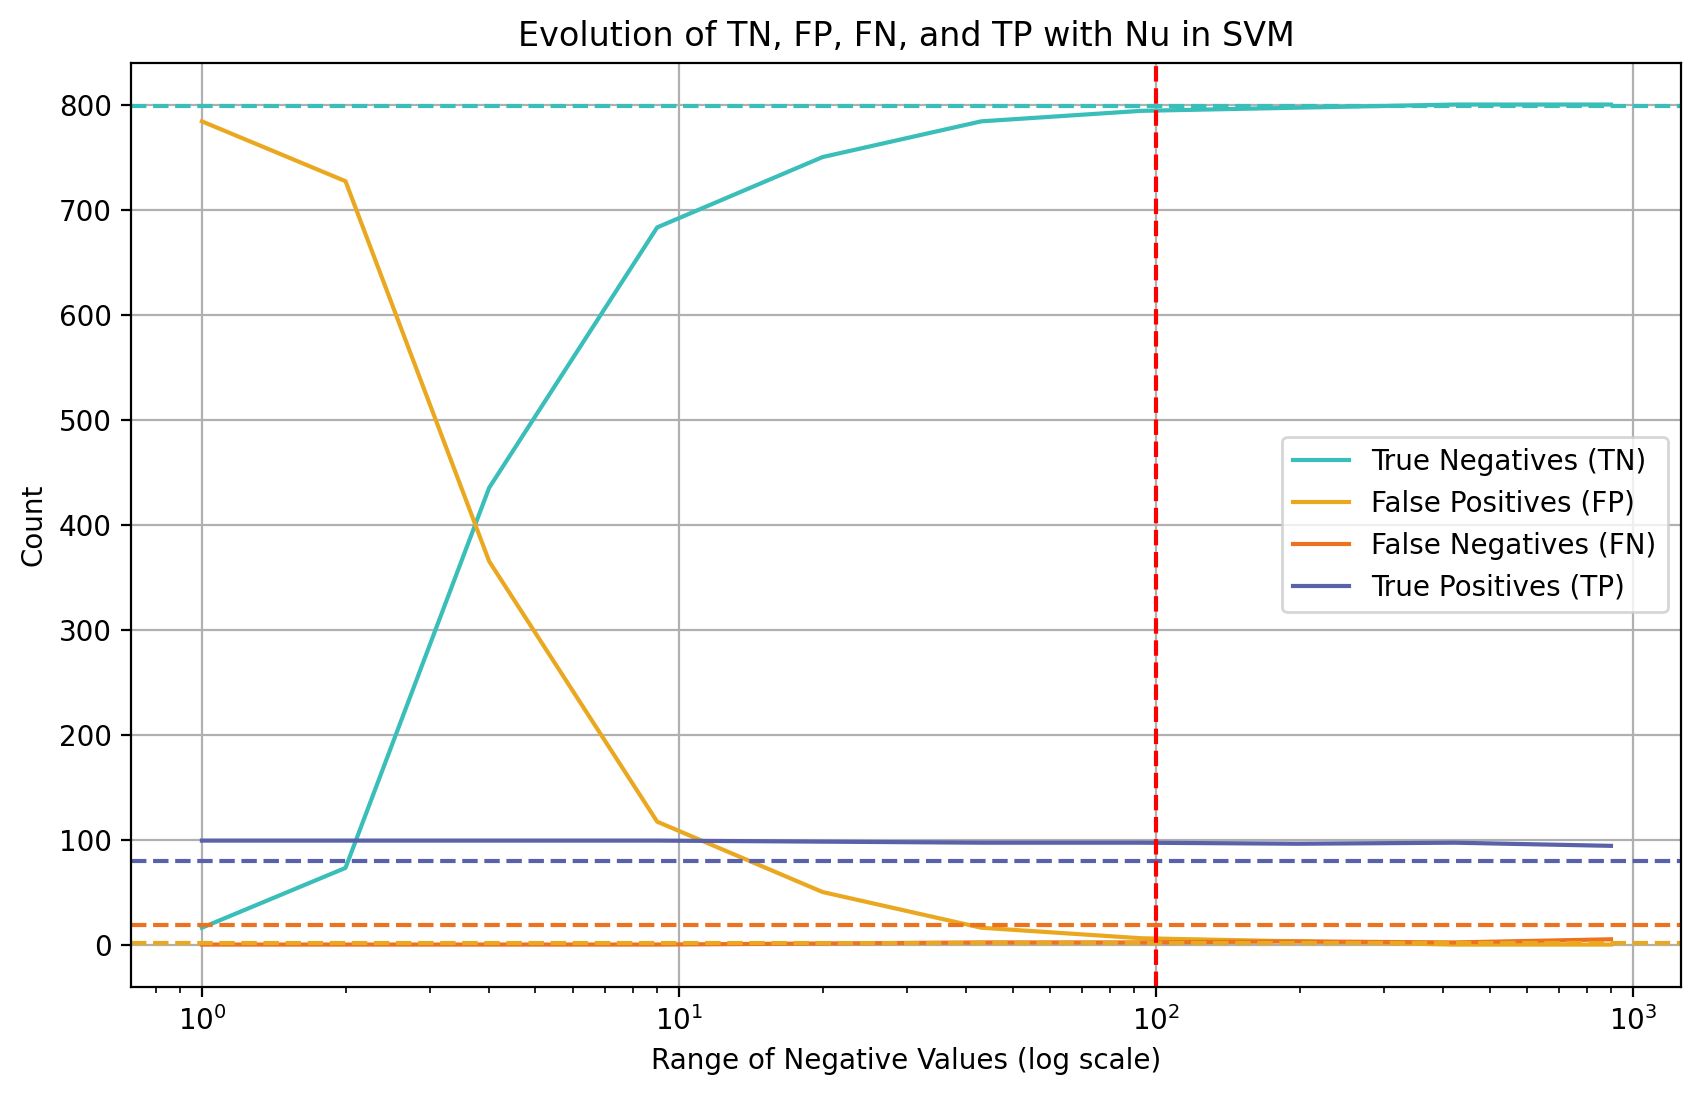

In [72]:
tn2, fp2, fn2, tp2 = simulate_svm(X_train, X_test, y_train, y_test, just_fives, log_range)


plt.figure(figsize=(10, 6))
plt.plot(np.array(log_range), tn2, label='True Negatives (TN)', color = '#39beb9' )
plt.plot(log_range, fp2, label='False Positives (FP)', color = '#eaa821')
plt.plot(log_range, fn2, label='False Negatives (FN)', color = '#ec7220')
plt.plot(log_range, tp2, label='True Positives (TP)', color = '#5861aa')
plt.axhline(y=tn[3], color='#39beb9', linestyle='--')
plt.axhline(y=fp[3], color='#eaa821', linestyle='--')
plt.axhline(y=fn[3], color='#ec7220', linestyle='--')
plt.axhline(y=tp[3], color='#5861aa', linestyle='--')
plt.axvline(x=100, color='red', linestyle='--')

plt.xlabel('Range of Negative Values (log scale)')
plt.ylabel('Count')
plt.title('Evolution of TN, FP, FN, and TP with Nu in SVM')
plt.legend()
plt.xscale("log")
plt.grid(True)
plt.show()

**Discussion**

Discuss the evolution of the 4 performance magnitudes as the number of negative samples in the training set increases.

Notice the OneClassSVM can be regarded as 0 negative samples. Is there any range of values of negative instances for which in any performance measure the OneClassSVM performs better than the SVM?

The main takeaways of this plot are:

* At the beggining we have a lot of negative samples considered positives (FP) but when we keep ading negative samples to the training set, this number decrease considerably.
* Regarding the TN we can observe how this number increases when the number of negative samples also increases. This is beause the model is being trained with more negative instances, making easier for ir to predict them.
* The TP and FN lines are constant.

When we increase the size of the range of negative values we can see clearly how our performance improves. The number of true negatives increases as the number of false positive decreases. As we are feeding the model some observations that represent novelty the model is better trained to classify them when it encounters them in the test.range_nu. We may take into account that increasing the number of novelties improves consideably the performance, but overall it ends up converging to the values of the best nu. This is because when you have inbalanced classes, then the model cannot predict accuratly the class that is unnumbered, but as you increase it the model can better predict the novelty class.

## 3.2 Supervision in the without 5, 6, 7, 8, and 9 task


Repeat section 3.1 but now in the task in which the negative class are digits 5, 6, 7, 8 and 9 and the positive class is formed by digits 0, 1, 2, 3, 4.

Include in you discussion the comparison between the three tasks.

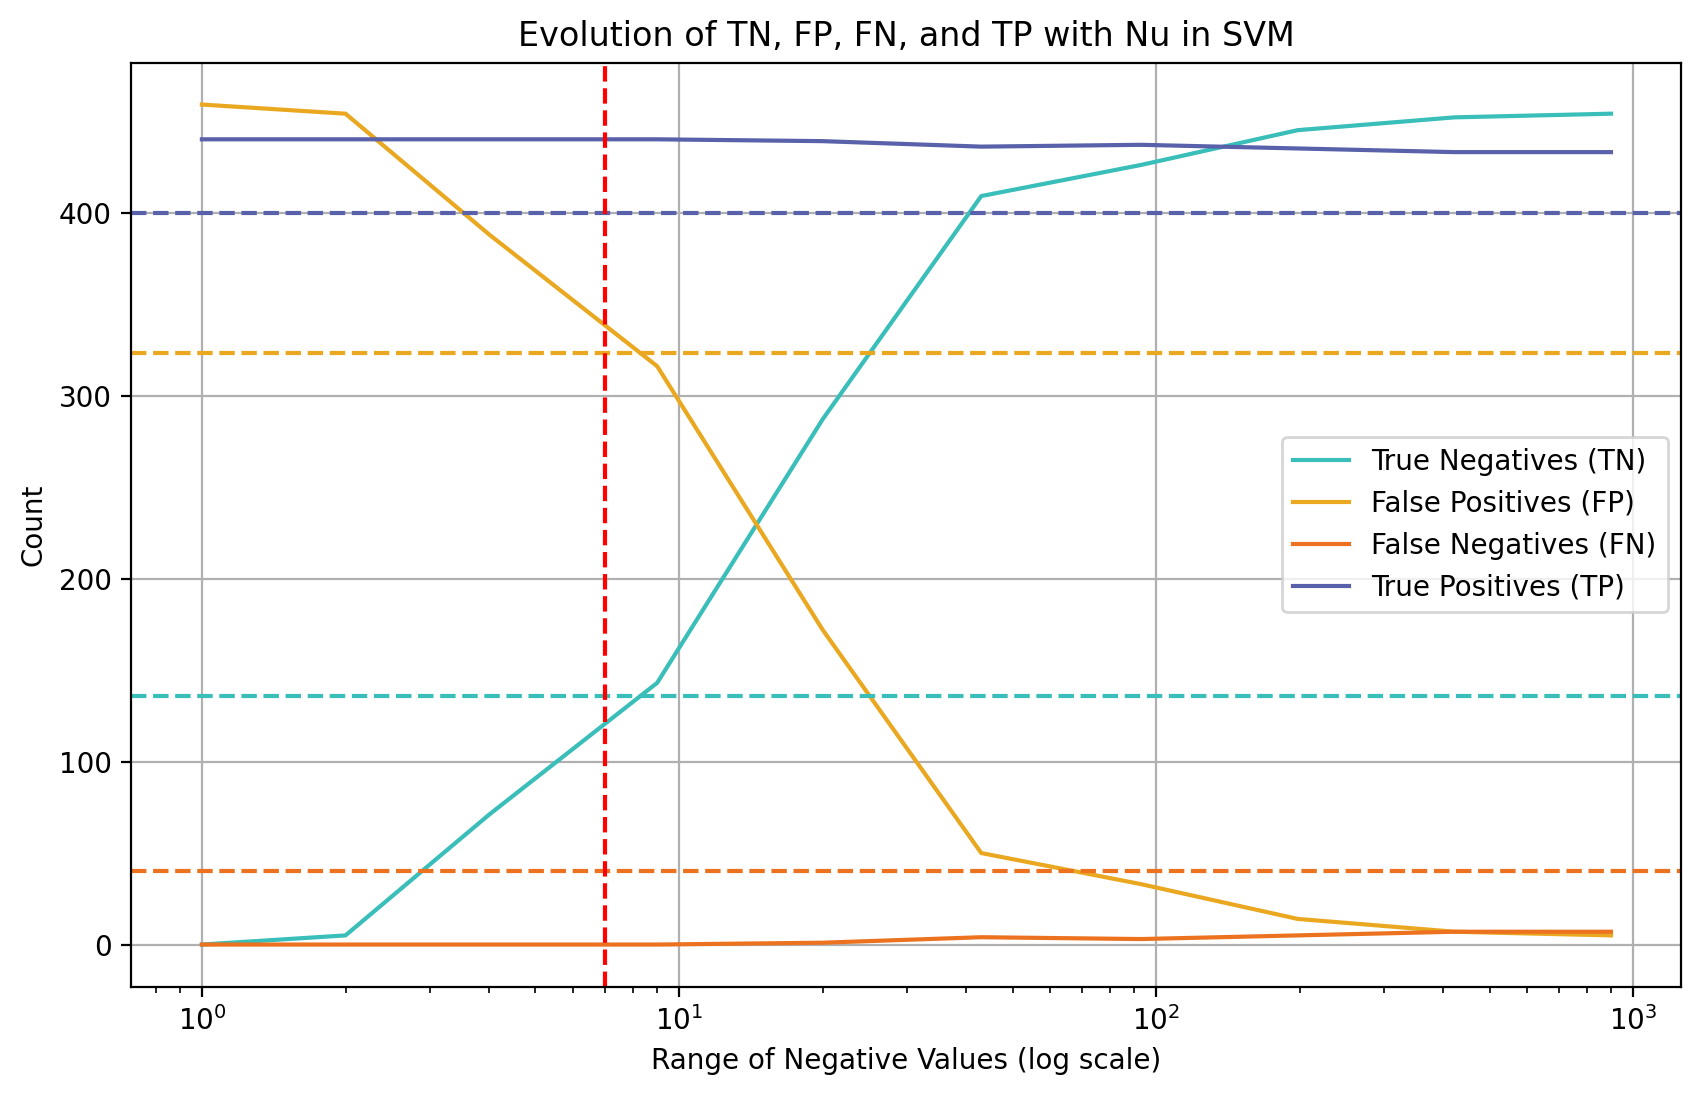

In [73]:
tn3, fp3, fn3, tp3 = simulate_svm(X_train, X_test, y_train, y_test, zero_four, log_range)
plt.figure(figsize=(10, 6))
plt.plot(np.array(log_range), tn3, label='True Negatives (TN)', color = '#39beb9' )
plt.plot(log_range, fp3, label='False Positives (FP)', color = '#eaa821')
plt.plot(log_range, fn3, label='False Negatives (FN)', color = '#ec7220')
plt.plot(log_range, tp3, label='True Positives (TP)', color = '#5861aa')
plt.axhline(y=tn_04[3], color='#39beb9', linestyle='--')
plt.axhline(y=fp_04[3], color='#eaa821', linestyle='--')
plt.axhline(y=fn_04[3], color='#ec7220', linestyle='--')
plt.axhline(y=tp_04[3], color='#5861aa', linestyle='--')
plt.axvline(x=7, color='red', linestyle='--')

plt.xlabel('Range of Negative Values (log scale)')
plt.ylabel('Count')
plt.title('Evolution of TN, FP, FN, and TP with Nu in SVM')
plt.legend()
plt.xscale("log")
plt.grid(True)
plt.show()

Here, a similar effect takes place. The true negatives increase and the false positive decrease. The only difference being the true positive which are higher at a constant level. Here we can detect that the model is really superior to its antecessor. Matter fact it outshines it for large values in the log scale.

# 4. Conclusions


- Which of the novelty detection taks is more difficult? A task is more difficult as it is harder to yield good performance

We would say that the most difficult task is predicting the classes of all 5 different numbers. This is because when detecting fives you only need to understand the shape of a number and it is easier to discard other observations, you can focus on specific characteristics of a given class. This being the reason for the good performance of the model 2.11. Moreover, the accuarcy of only predicting 5s was 0.97 and for the 0 to 4 was only 0.6 at max.

However when trying to predict 5 different numbers with novelty detection there are a lot of misclassified instances and less number of observations per class. This may be because the novelties are in the form of some numbers the model has not seen previously and the model has to better adapt to different numbers.



- For each task, which is the amount of supervision (number of negative labelled observations in the training set) that makes SVM outperform OneClassSVM?

    - For the first task we can see that we move in the magnitude of 100 observations to make SVM the best model. When the number of negative labelled observations in the training set is more or less 60 ,the SVM outperform OneClassSVM
    - For the second one we need more or less 7 to start to see noticeable changes in performance.